## Jaccard-based network evaluation
Large experiment with jaccard distance. Sample size is 9000 the rest is used for evaluation. For $\gamma$ values from 0 to 1.0
first a reference network is created, and subseqently data are diveded into 8 partitions, for each partition a network is created,
afterwards the partition networks are merged (one-shot). 



In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from appknn import lcl, vote
from glob import glob
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from tabulate import tabulate


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
def make_plot(colnames, alldata):
    plt.figure(figsize=(12,8))
    plt.title(f"Comparision of: {' '.join(colnames)}")
    for colname in colnames:
        plt.plot(alldata[f"{colname}_mer"], label=f"merged: {colname}")
        plt.plot(alldata[f"{colname}_ref"], label=f"reference: {colname}")
        
    plt.xlabel(r"$\gamma$")
    plt.legend();

In [3]:
#alldata = pd.read_csv('res/out.csv', index_col=0)
alldatajac = pd.read_csv('res/jaccards.csv', index_col=0)

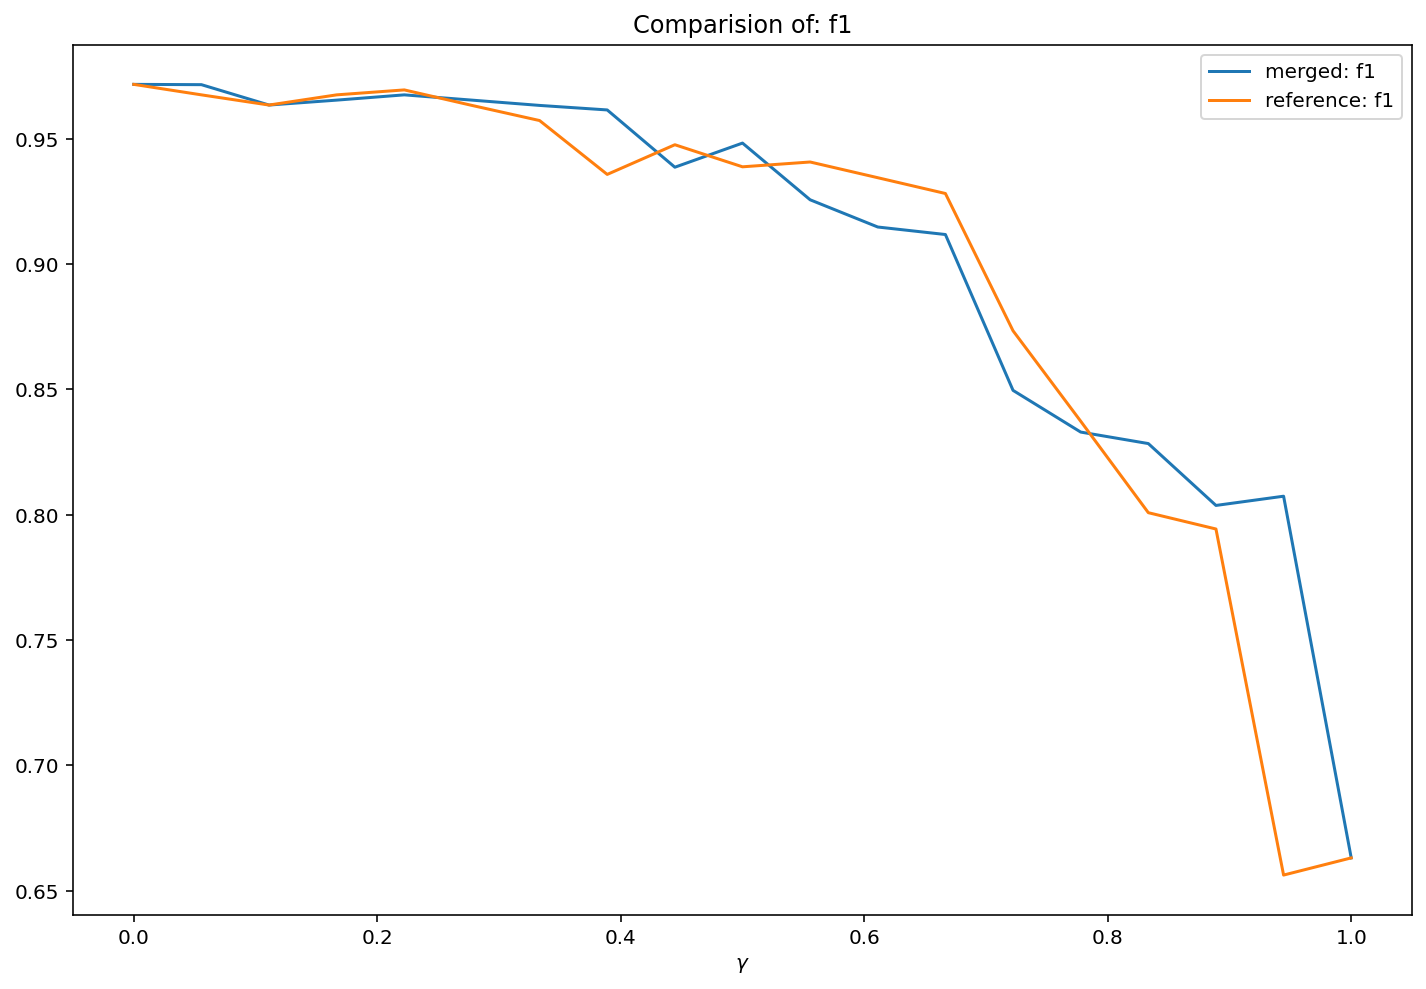

In [4]:
make_plot(["f1"], alldatajac)

In [5]:
def get_data():
    m = pd.read_csv('data/joined.csv', index_col='apn')
    m['nf'] = m['nf'].apply(eval)
    return m

m = get_data()

distance = lambda x,y: jaccard(x,y, m['nf'])
classifier = lambda x: lcl(x, m['ml'])

test = pd.read_csv('res/10003-test.csv', index_col=0)
true_values = [vote(classifier(a)) for a in test.index]

In [6]:
with open(f"res/preds-refs.pickle", 'rb') as f:
    refs = pickle.load(f)

prc = dict()
for gamma, probs in refs.items():
    prc[gamma]=precision_recall_curve(true_values, probs)

In [7]:
list(refs.keys())

[0.0,
 0.05555555555555555,
 0.1111111111111111,
 0.16666666666666666,
 0.2222222222222222,
 0.2777777777777778,
 0.3333333333333333,
 0.3888888888888889,
 0.4444444444444444,
 0.5,
 0.5555555555555556,
 0.6111111111111112,
 0.6666666666666666,
 0.7222222222222222,
 0.7777777777777778,
 0.8333333333333334,
 0.8888888888888888,
 0.9444444444444444,
 1.0]

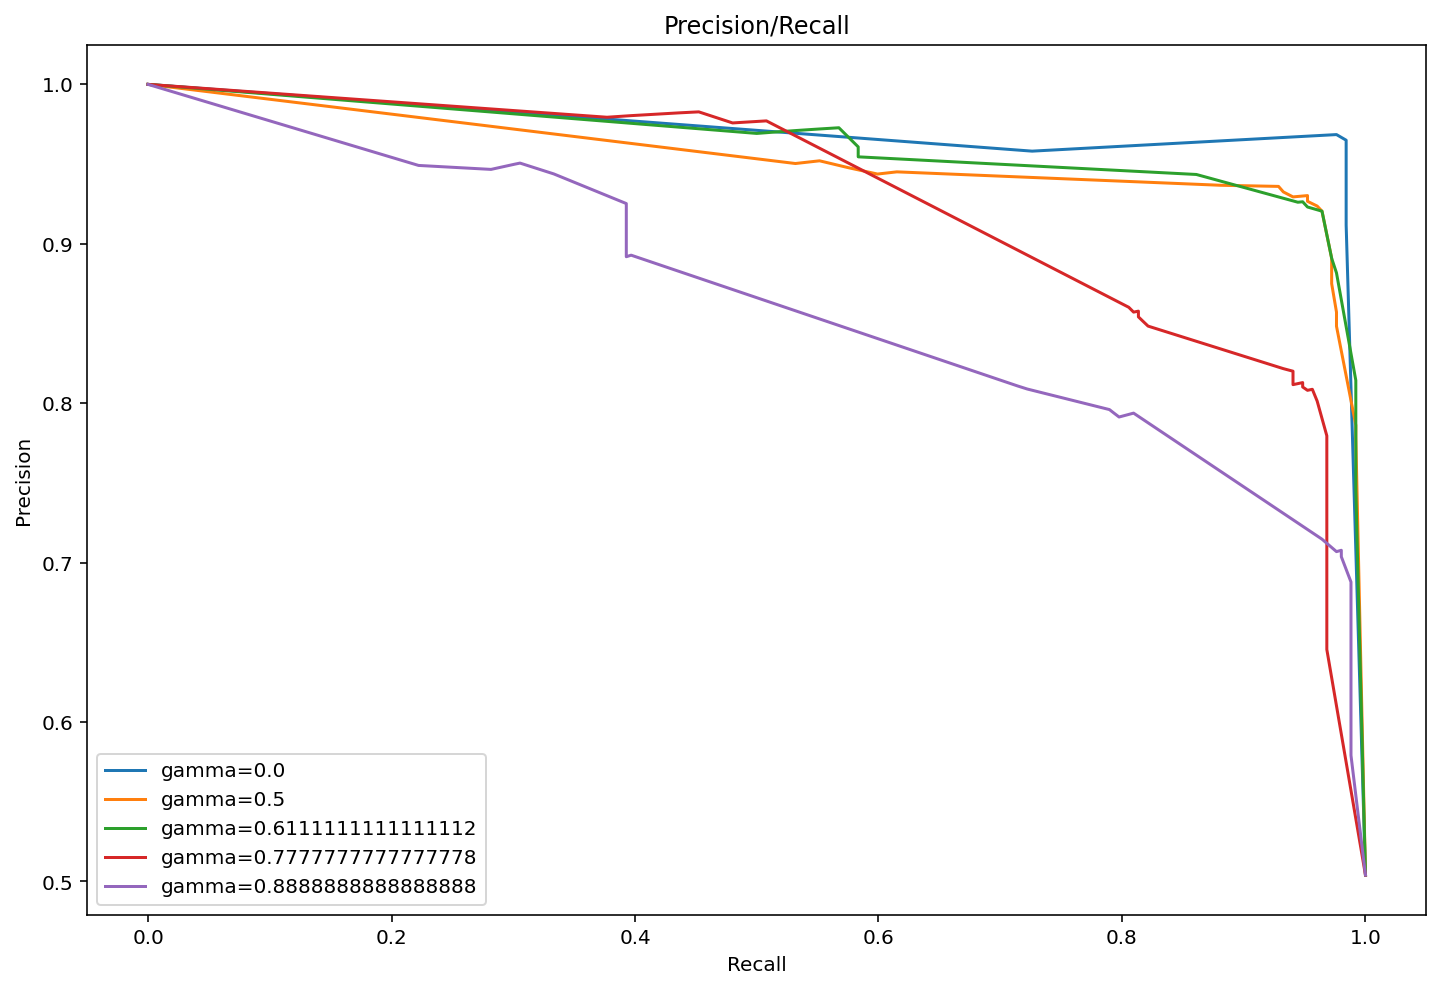

In [8]:
plt.figure(figsize=(12,8))
plt.title('Precision/Recall')

gammas = [0.0, 0.5, 0.6111111111111112, 0.7777777777777778, 0.8888888888888888]

for gamma in gammas:
    [precisons, recalls, thresholds] = prc[gamma]
    plt.plot(recalls, precisons, label=f"{gamma=}")
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();


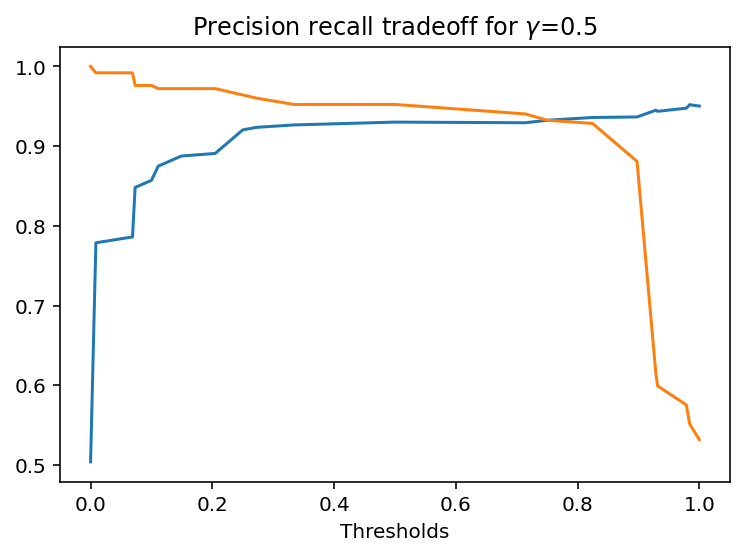

In [9]:
def plot_tradeoff(prc, gamma):
    [precisons, recalls, tlo] = prc[gamma]
    plt.title(f"Precision recall tradeoff for $\gamma$={gamma}")
    plt.plot(tlo, precisons[:-1])
    plt.plot(tlo, recalls[:-1]);
    plt.xlabel('Thresholds')
    
plot_tradeoff(prc, 0.5)

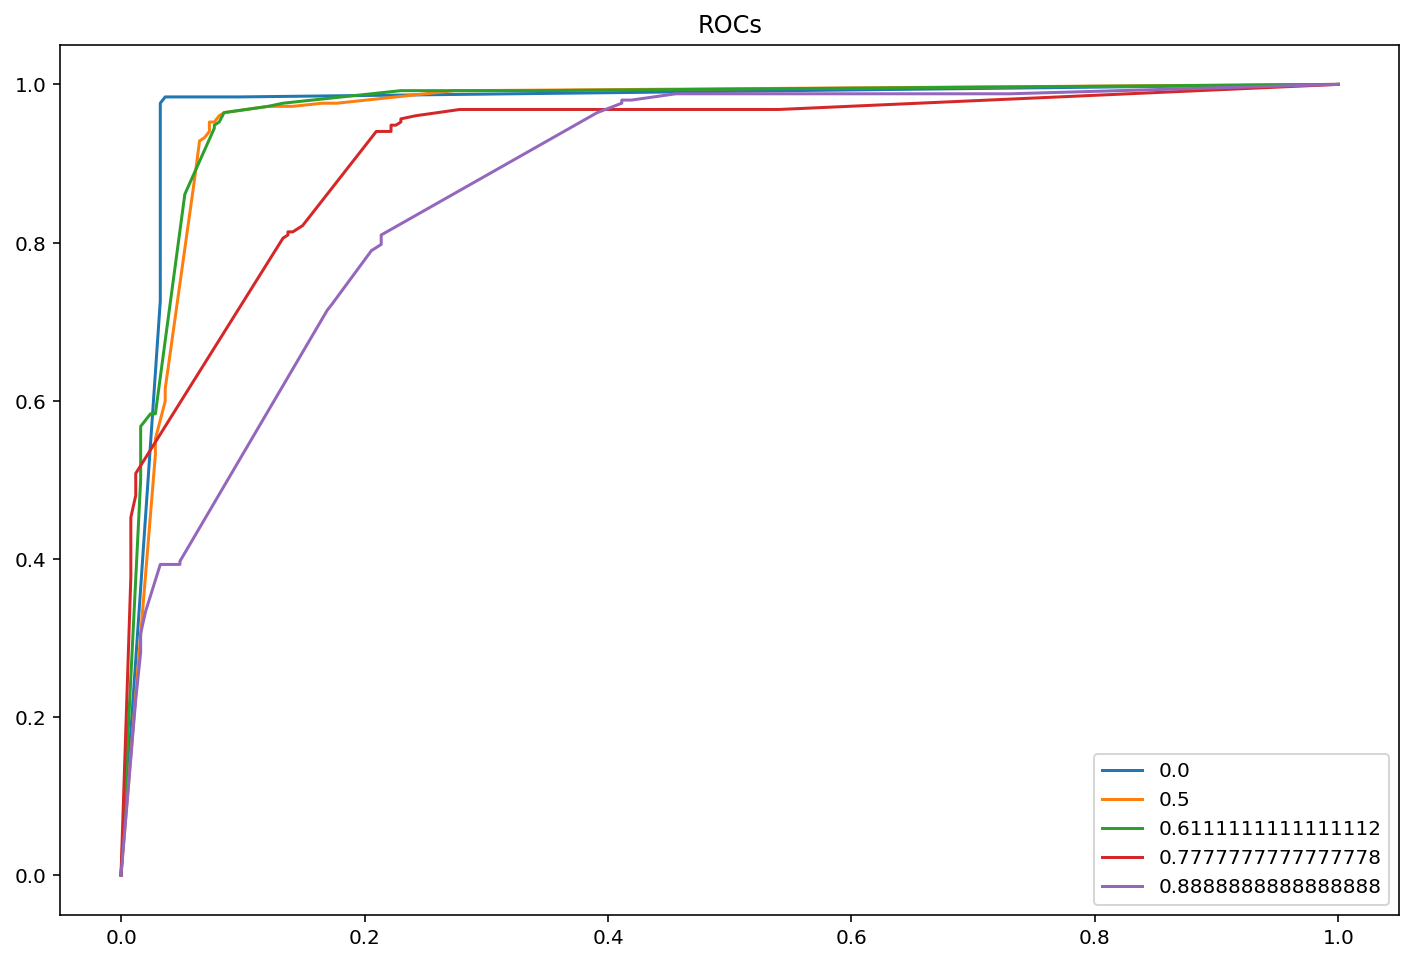

In [10]:
plt.figure(figsize=(12,8))
plt.title("ROCs")
for gamma in gammas:
    fpr, tpr, thr = roc_curve(y_true=true_values, y_score=refs[gamma])
    plt.plot(fpr, tpr, label=f"{gamma}");
    
plt.legend();

In [46]:
lines = list()
for gamma in gammas:
    lines.append([gamma, roc_auc_score(y_true=true_values, y_score=refs[gamma])])
    
tabulate(lines, headers=['gamma', 'AUC'], tablefmt="html")

gamma,AUC
0.0555556,0.970542
0.111111,0.967686
0.166667,0.969166
0.222222,0.973854
0.277778,0.975238
0.333333,0.974702
0.388889,0.952149
0.444444,0.965686
0.5,0.96123
0.555556,0.96615


In [11]:
with open('res/9503-jaccard-votingnets.pickle', 'rb') as f:
    nets = pickle.load(f)

In [12]:
ref, mer = nets[0.0]
siz = sum(map(sum, ref.values()))
sm = sum(map(sum, mer.values()))
print(f"Overal number of votes in the network (==sample size) {siz} {sm}")

Overal number of votes in the network (==sample size) 9503 9503


In [13]:
alldatajac['comp_mer']  = alldatajac.anchors_mer / siz
alldatajac['comp_ref']  = alldatajac.anchors_ref / siz

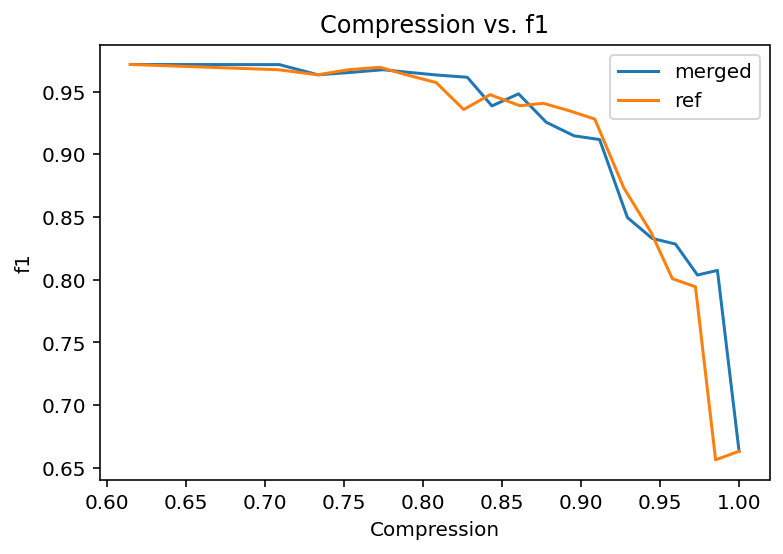

In [14]:
plt.title('Compression vs. f1')
plt.plot(1-alldatajac.comp_mer, alldatajac.f1_mer, label='merged')
plt.plot(1-alldatajac.comp_ref, alldatajac.f1_ref, label='ref')
plt.xlabel('Compression')
plt.ylabel('f1')
plt.legend();


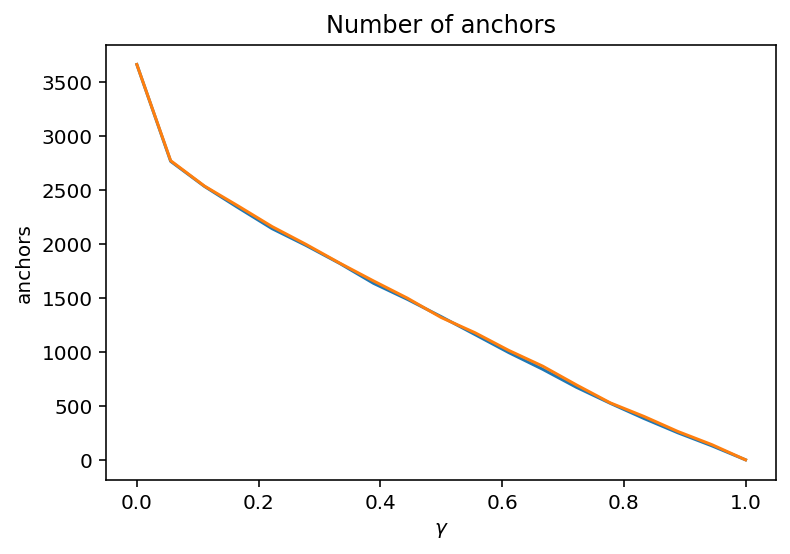

In [15]:
plt.title("Number of anchors")
plt.plot(alldatajac.anchors_mer, label='merged')
plt.plot(alldatajac.anchors_ref, label='ref')
plt.xlabel(r"$\gamma$")
plt.ylabel('anchors');


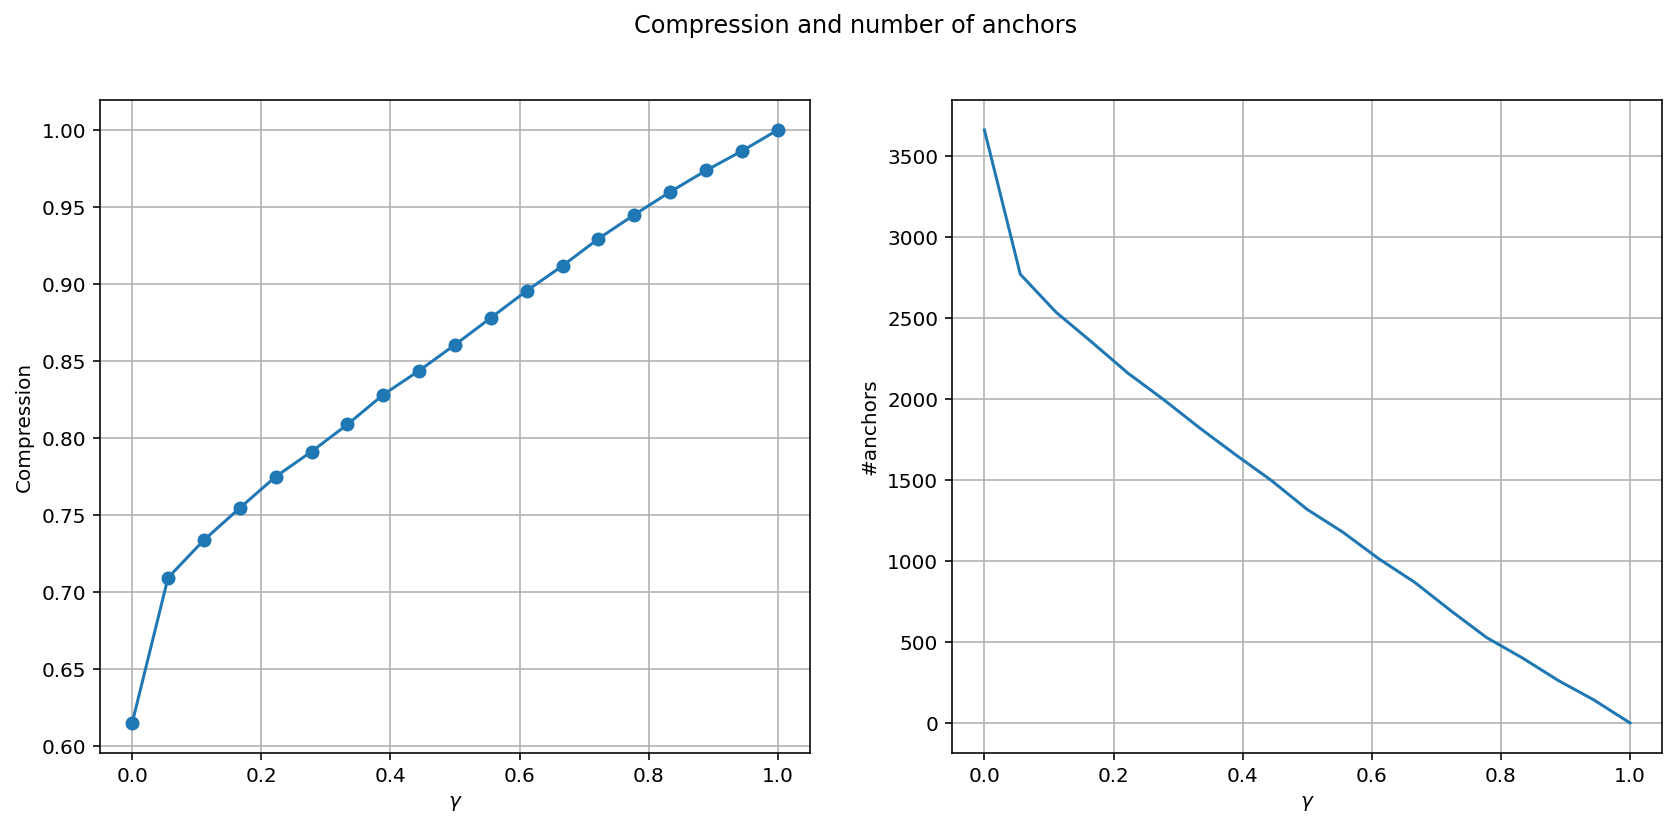

In [16]:
#plt.plot('Compressio')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
fig.suptitle("Compression and number of anchors")
ax1.plot(alldatajac.index, 1-alldatajac.comp_mer,'-o', label='merged')
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('Compression')
ax1.grid()
ax2.plot(alldatajac.anchors_ref, label='ref');
ax2.set_xlabel('$\gamma$')
ax2.grid()
ax2.set_ylabel('#anchors');

## Votes distribution

For each value of gamma, the amount of anchors with majority vote for bening and malicious are claculated. Apparently, depsite the equal distribution of mal/ben in sample, the malware anchors are less frequent for smaller gammas (more compressed?). 

In [17]:
test = pd.read_csv("res/10003-test.csv", index_col=0)
test_classes = [int(vote(classifier(t))) for t in test.index]
print("Malware apps in test set:", sum(test_classes)/len(test_classes))

Malware apps in test set: 0.504


In [18]:
def get_anchor_classes(net):
    anch = [int(mal>bi) for  k, [mal, bi] in net.items()]
    return sum(anch), len(anch)

In [19]:
res = dict()
for gamma, [mer,ref] in nets.items():
    res[gamma] = [*get_anchor_classes(mer), *get_anchor_classes(ref) ]
    
df = pd.DataFrame.from_dict(res, orient='index', columns=['mal_mer', 'all_mer', 'mal_ref', 'all_ref'])

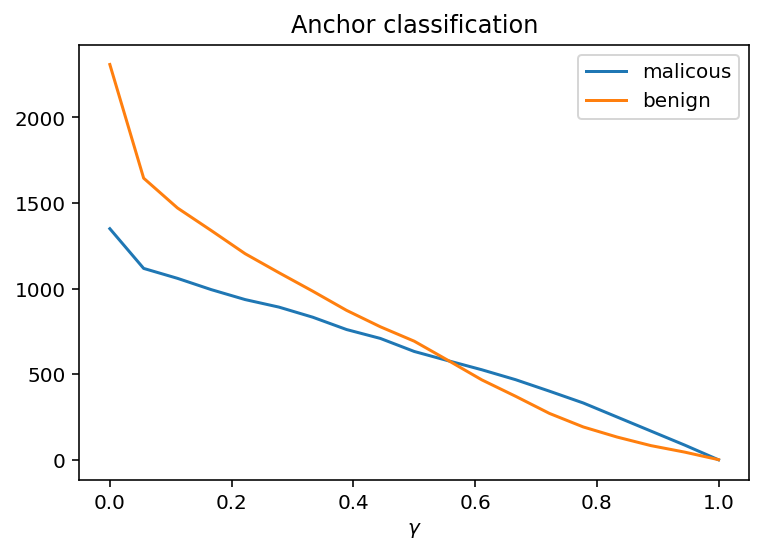

In [20]:
plt.title('Anchor classification')
plt.plot(df.mal_mer, label='malicous')
plt.plot(df.all_mer-df.mal_mer, label='benign')
plt.xlabel(r"$\gamma$")
plt.legend();

## Influence of the training sample size
Based on the previous results we fix the value of $\gamma=0.7$ and train the network on sample size of different size. Additionally, different seeds are used to generate the data set and check the model vairance. 

In [21]:

dfs = list()
for n in glob('res/ad-?.csv'):
    dfs.append(pd.read_csv(n, index_col=0))

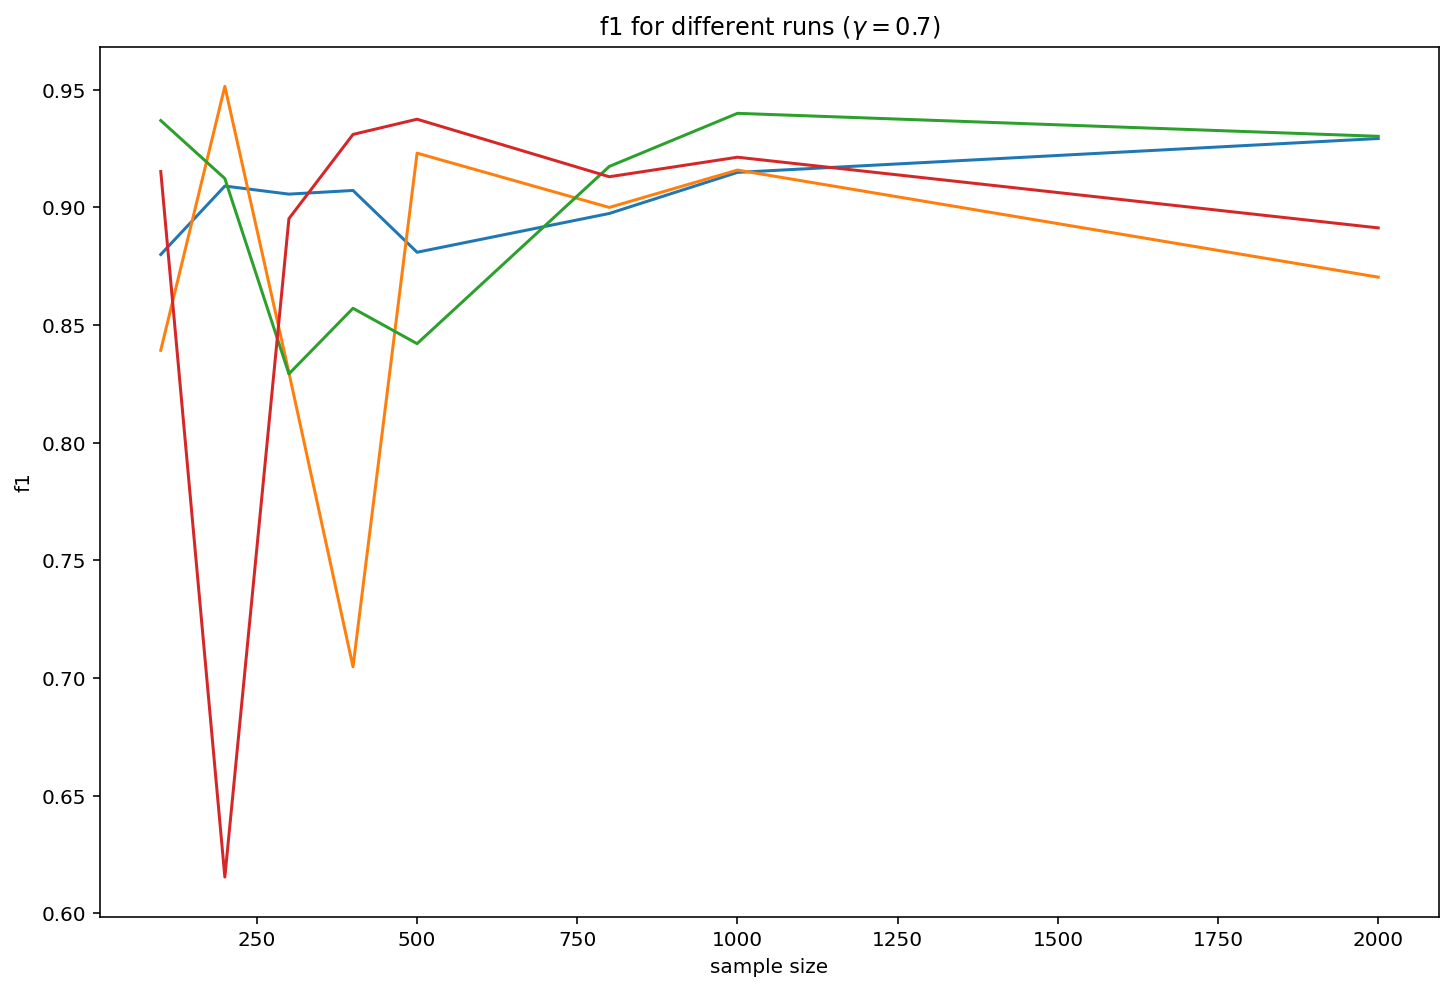

In [22]:
plt.figure(figsize=(12, 8))
plt.title('f1 for different runs ($\gamma=0.7$)')
for e in dfs:
    plt.plot(e.f1)
plt.ylabel('f1')
plt.xlabel('sample size');

## Effective $\gamma$

Setup: 8 partitions, calcluate network for each, merge hierarchically. 

Question: how much apps will be missassigned in the final network, i.e., thier distance to the anchor will be larger than gamma. 

Rationale: this kind of effect does not appear in one shot merging (probably?) nor in reference network.

In [23]:
from appknn import jaccard
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
def get_missed(net, gamma, distance=jaccard):
    ret = dict()
    for anchor, klist in net.items():
        for k in klist:
            if (d:=distance(anchor, k, funcs)) > gamma:
                ret[k] = d
                
    overal = sum(map(len, net.values()))+len(net)
    print(f"Found {len(ret)} ({100.0*len(ret) / overal:.2f}%) apps at distance>{gamma} in the network. Max {max(ret.values(), default=0)}")
    
    return ret

In [25]:
v = pd.read_csv('data/functions_encoded.csv')
funcs = v.groupby(by='apn')['nf'].apply(set)

In [26]:
missed = dict()
for an in glob('res/mergers*.pickle'):
    w =an.split('-')[-1][:-len('.pickle')]
    gamma = float(w)
    with open(an, 'rb') as f:
        reference, merged = pickle.load(f)
    missed[gamma] = get_missed(merged, gamma)

    
mi = dict(sorted(missed.items(), key=lambda x: x[0]))

vals = {gamma: len(a.values()) for gamma,a in mi.items()}
maxes = {gamma: max(a.values(), default=0) for gamma, a in mi.items()}

Found 802 (8.02%) apps at distance>0.5555555555555556 in the network. Max 0.9791213571117877
Found 334 (3.34%) apps at distance>0.3333333333333333 in the network. Max 0.5878915760428503
Found 0 (0.00%) apps at distance>0.0 in the network. Max 0
Found 0 (0.00%) apps at distance>1.0 in the network. Max 0
Found 270 (2.70%) apps at distance>0.2222222222222222 in the network. Max 0.3710741620480338
Found 196 (1.96%) apps at distance>0.2777777777777778 in the network. Max 0.5878915760428503
Found 863 (8.63%) apps at distance>0.9444444444444444 in the network. Max 1.0
Found 1228 (12.28%) apps at distance>0.6666666666666666 in the network. Max 0.9946236559139785
Found 156 (1.56%) apps at distance>0.16666666666666666 in the network. Max 0.3071098022717711
Found 1385 (13.85%) apps at distance>0.8333333333333334 in the network. Max 1.0
Found 448 (4.48%) apps at distance>0.4444444444444444 in the network. Max 0.7012967655388285
Found 772 (7.72%) apps at distance>0.6111111111111112 in the network. 

In [27]:
import numpy as np
means = {gamma: np.mean(list(a.values())) for gamma, a in mi.items() if gamma!=1.0 and gamma!=0}


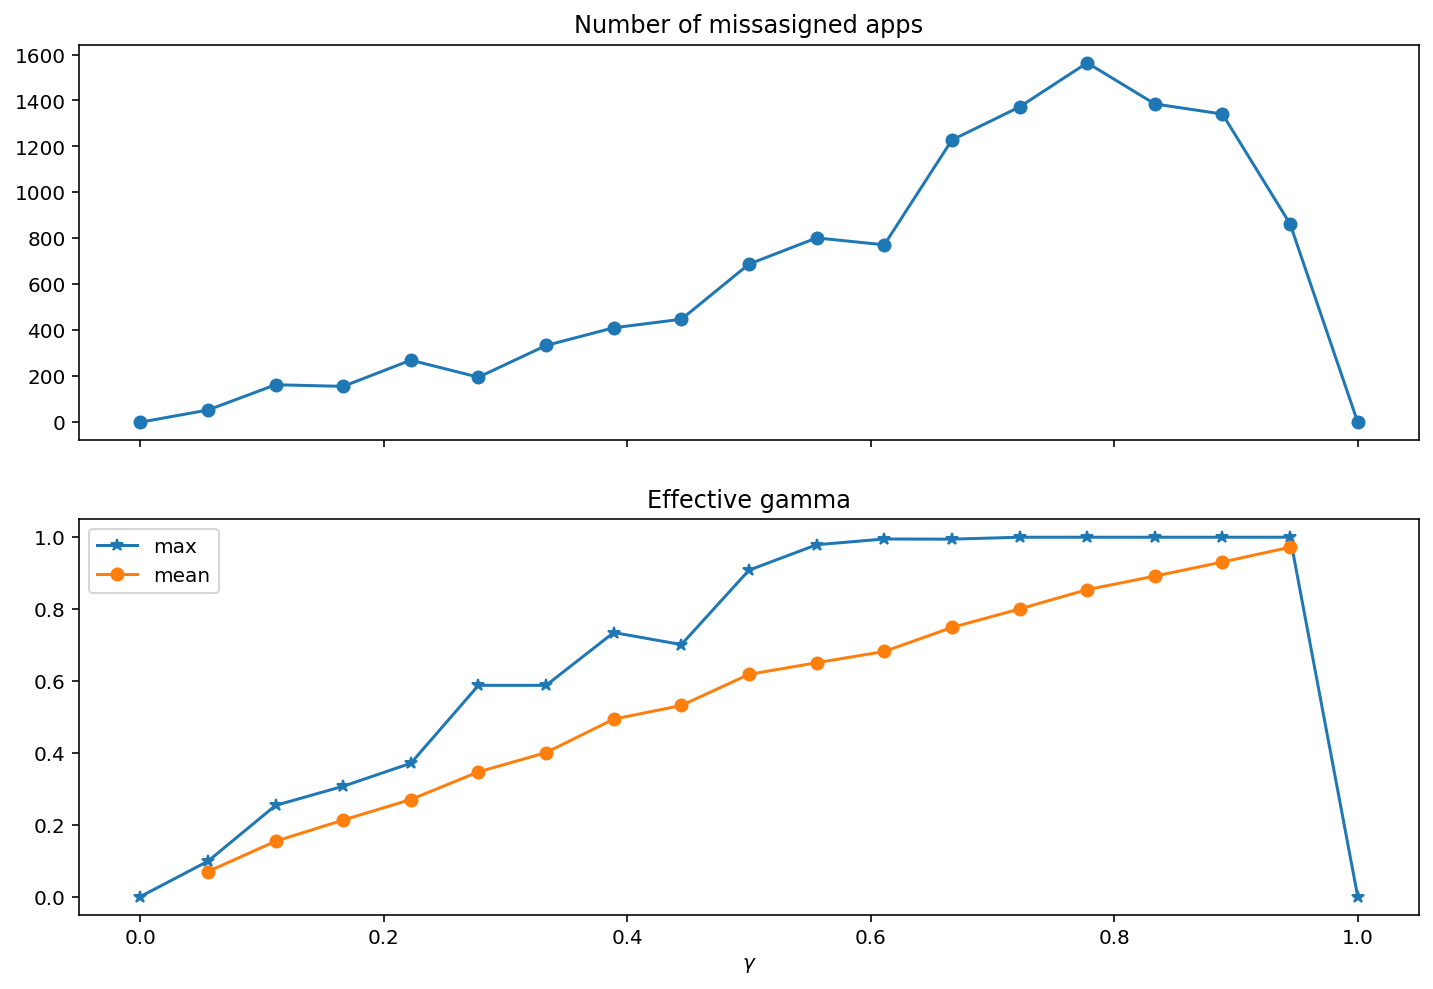

In [28]:

fig, (ax1, ax2) = plt.subplots( 2, figsize=(12,8), sharex=True)

ax1.set_title('Number of missasigned apps')
ax1.plot(vals.keys(), vals.values(), '-o')

ax2.set_title('Effective gamma')
ax2.plot(maxes.keys(), maxes.values(), '-*', label='max')
ax2.plot(means.keys(), means.values(), '-o', label='mean')
ax2.legend()


ax1.label_outer()
ax2.label_outer()
ax2.set_xlabel('$\gamma$');

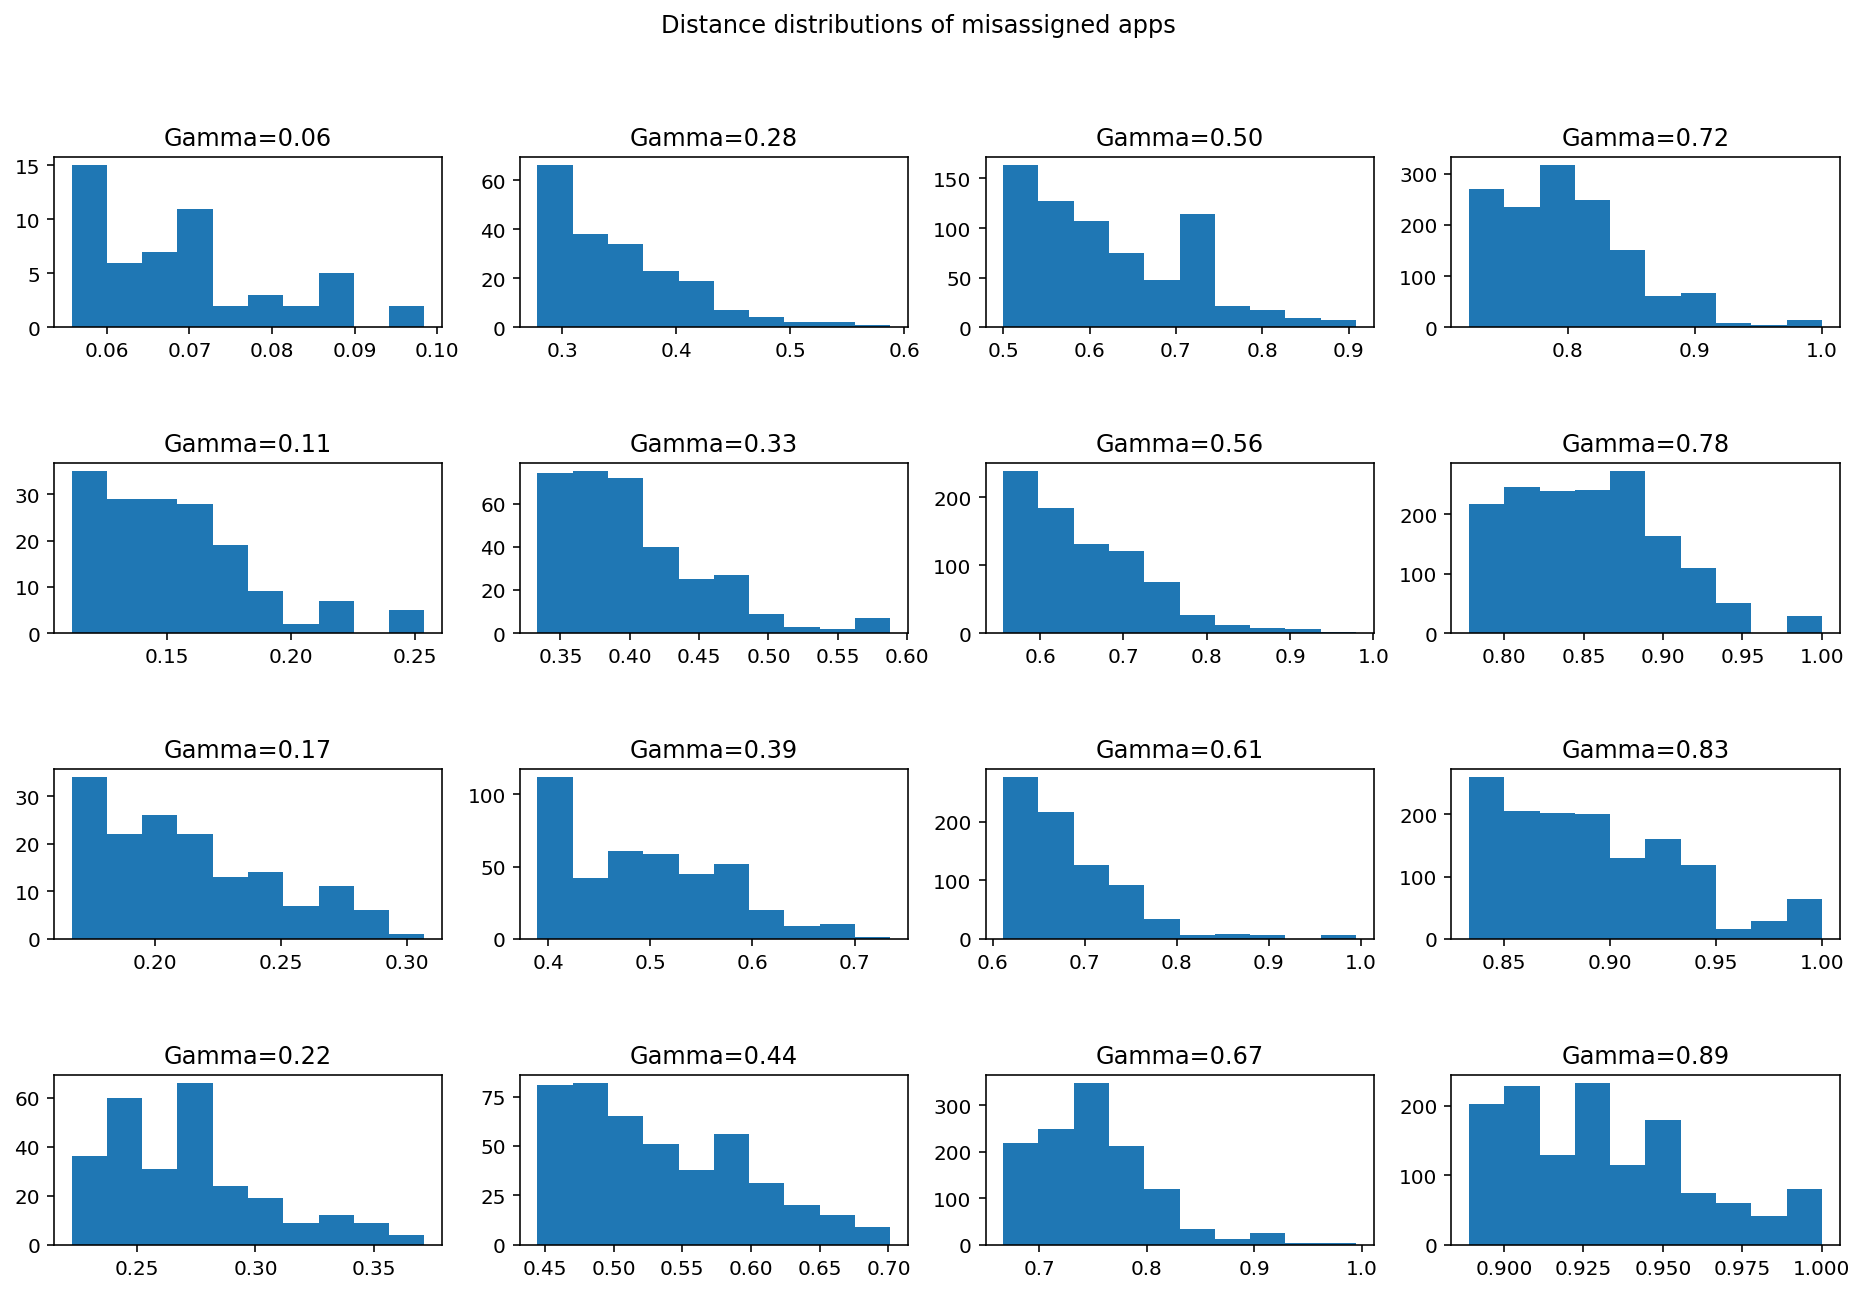

In [29]:
gammas = list(mi.keys())
gammas.remove(0.0)

rowsize = 4
fig, axes = plt.subplots(nrows=rowsize,ncols=(1+len(gammas))//rowsize, figsize=(16,10))
fig.suptitle("Distance distributions of misassigned apps")
for j, row in enumerate(axes):
    for i, cols in enumerate(row):
        idx = i * rowsize + j
        cols.set_title(f"Gamma={gammas[idx]:.2f}")
        cols.hist(mi[gammas[idx]].values());
fig.subplots_adjust(hspace = 0.8)

## Distance distribution

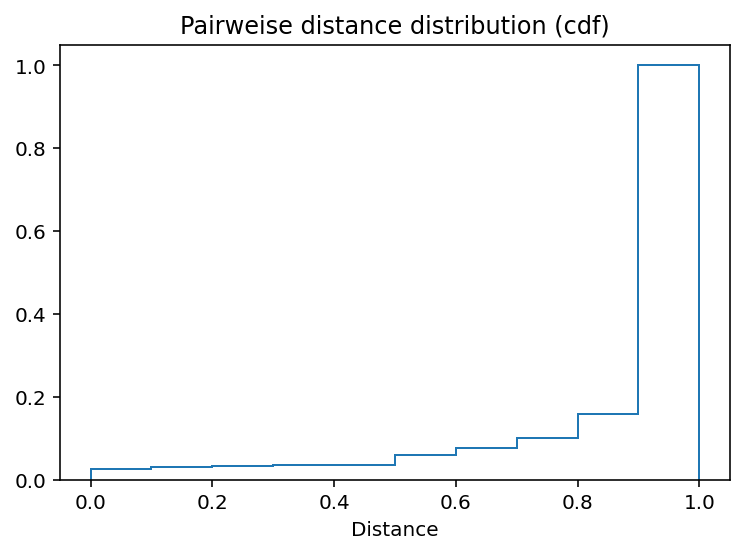

In [30]:
with open('res/distances-jaccard.pickle', 'rb') as f:
    distances = pickle.load(f)

plt.title('Pairweise distance distribution (cdf)')
plt.xlabel('Distance')
plt.hist(distances,  cumulative=True, histtype='step', density=True);

## Notes

In [31]:
#0.666667    0.911765
# r-score vs. run time? (moving from right gamma=1.0 to 0, )
# compare performance of small and large data set (only reference?)
# interpreate small model
# what-if: chnage features of test to see if the classification chnaged